# Business Insights in the Used Car Market

### Setup

In [237]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import os
import matplotlib.ticker as mtick
from matplotlib import rc
rc('text', usetex=False)

In [2]:
csv_file = 'vehicles.csv'

In [18]:
df = pd.read_csv(csv_file)
df.head()

id                                                url  \
0  7222695916  https://prescott.craigslist.org/cto/d/prescott...   
1  7218891961  https://fayar.craigslist.org/ctd/d/bentonville...   
2  7221797935  https://keys.craigslist.org/cto/d/summerland-k...   
3  7222270760  https://worcester.craigslist.org/cto/d/west-br...   
4  7210384030  https://greensboro.craigslist.org/cto/d/trinit...   

                   region                         region_url  price  year  \
0                prescott    https://prescott.craigslist.org   6000   NaN   
1            fayetteville       https://fayar.craigslist.org  11900   NaN   
2            florida keys        https://keys.craigslist.org  21000   NaN   
3  worcester / central MA   https://worcester.craigslist.org   1500   NaN   
4              greensboro  https://greensboro.craigslist.org   4900   NaN   

  manufacturer model condition cylinders  ... size  type paint_color  \
0          NaN   NaN       NaN       NaN  ...  NaN   NaN         NaN   
1          NaN   NaN       NaN       NaN  ...  NaN   NaN         NaN   
2          NaN   NaN       NaN       NaN  ...  NaN   NaN         NaN   
3          NaN   NaN       NaN       NaN  ...  NaN   NaN         NaN   
4          NaN   NaN       NaN       NaN  ...  NaN   NaN         NaN   

  image_url description county state lat long posting_date  
0       NaN         NaN    NaN    az NaN  NaN          NaN  
1       NaN         NaN    NaN    ar NaN  NaN          NaN  
2       NaN         NaN    NaN    fl NaN  NaN          NaN  
3       NaN         NaN    NaN    ma NaN  NaN          NaN  
4       NaN         NaN    NaN    nc NaN  NaN          NaN  

[5 rows x 26 columns]

In [19]:
df.columns

Index(['id', 'url', 'region', 'region_url', 'price', 'year', 'manufacturer',
       'model', 'condition', 'cylinders', 'fuel', 'odometer', 'title_status',
       'transmission', 'VIN', 'drive', 'size', 'type', 'paint_color',
       'image_url', 'description', 'county', 'state', 'lat', 'long',
       'posting_date'],
      dtype='object')

### Data Cleaning

In [20]:
#df['posting_date'] = pd.to_datetime(df['posting_date'], utc=True)
#df['posting_year_month'] = df['posting_date'].dt.to_period('M')

In [21]:
df.isnull().sum()

id                   0
url                  0
region               0
region_url           0
price                0
year              1205
manufacturer     17646
model             5277
condition       174104
cylinders       177678
fuel              3013
odometer          4400
title_status      8242
transmission      2556
VIN             161042
drive           130567
size            306361
type             92858
paint_color     130203
image_url           68
description         70
county          426880
state                0
lat               6549
long              6549
posting_date        68
dtype: int64

#### For the sake of data integrity, I will convert null values for the target columns to `unknown`, as well as converting some floats to numeric values. I will also drop unused columns for processing times.

In [22]:
# Data Cleaning
df.drop(columns=['url', 'region_url', 'VIN', 'image_url'], inplace=True)

df['manufacturer'] = df['manufacturer'].fillna('unknown')
df['model'] = df['model'].fillna('unknown')

In [23]:
# convert year to intergers
df['year'] = df['year'].astype('Int64')

# Pricing Strategy

## Price Distribution by Manufacturer

In [30]:
# Filter out extreme prices for better visualization
df_price_filtered = df[(df["price"] > 500) & (df["price"] < 100000)]

In [106]:
#### We limit this visualization to the top 5 manufacturers with the highest average price.
# manufacturer_price = df_price_filtered.groupby('manufacturer')['price'].mean().sort_values(ascending=False).head(10)

In [112]:
# Choosing the 10 most popular manufacturers
top_10_brand = df_price_filtered['manufacturer'].value_counts()[:10].index.tolist()
top_10_brand.remove('unknown')

In [114]:
df_price_filtered_top_10 = df_price_filtered[df_price_filtered["manufacturer"].isin(top_10_brand)]

## Box plot of price for top 10 popular manufacturers

/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


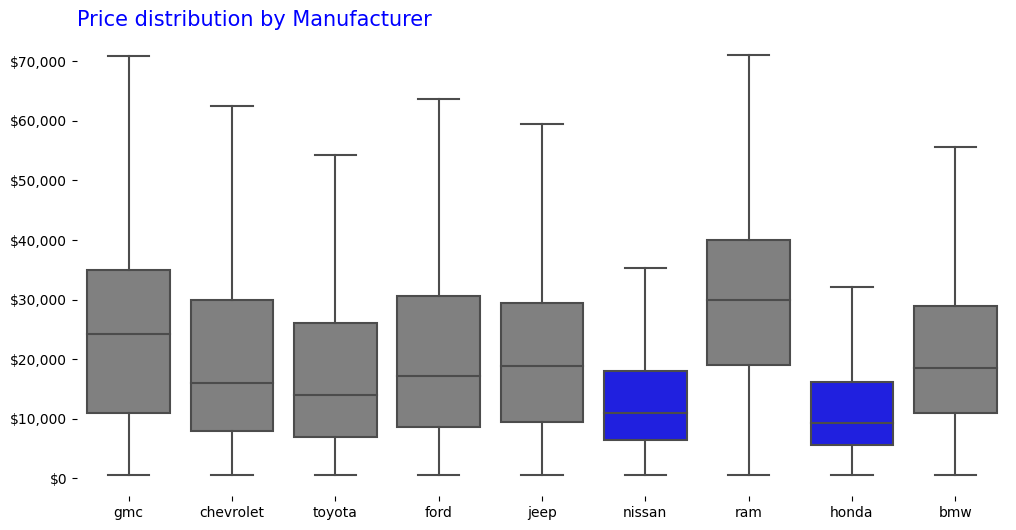

In [142]:
palette = {
    m: 'blue' if m.lower() in ['nissan', 'honda'] else 'gray'
    for m in df_price_filtered_top_10['manufacturer'].unique()
}

plt.figure(figsize=(12, 6))
ax = sns.boxplot(data=df_price_filtered_top_10, x="manufacturer", y="price",
                 palette=palette, showfliers=False)


# Remove the borders of the plot
for spine in ax.spines.values():
    spine.set_visible(False)

# Format y-axis ticks with dollar sign and commas
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick)

plt.title("Price distribution by Manufacturer", loc="left", fontsize=15, color="blue")
plt.ylabel("")
plt.xlabel("")

plt.show()

#### We see that Nissan and Honda used cars have the lowest ranges for price, providing some indications on how the models retain value after being on the secondary market.

#### However, in order to have a full analysis on best value in used cars, we would need to supplement this data with the original price of the model, which can be difficult to obtain given the manufacturers also adjust their prices based on market sentiment.

## Depreciation curve (Price vs. Year) with regression

In [123]:
from sklearn.linear_model import LinearRegression

# Filter valid year and price values
df_filtered = df[(df["year"] > 1990) & (df["price"] > 500) & (df["price"] < 100000)]

# Fit a linear regression model
X = df_filtered[["year"]].dropna()
y = df_filtered["price"].dropna()
model = LinearRegression()
model.fit(X, y)

# Predict prices using the regression model
years = np.array(range(df_filtered["year"].min(), df_filtered["year"].max() + 1)).reshape(-1, 1)
predicted_prices = model.predict(years)

/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


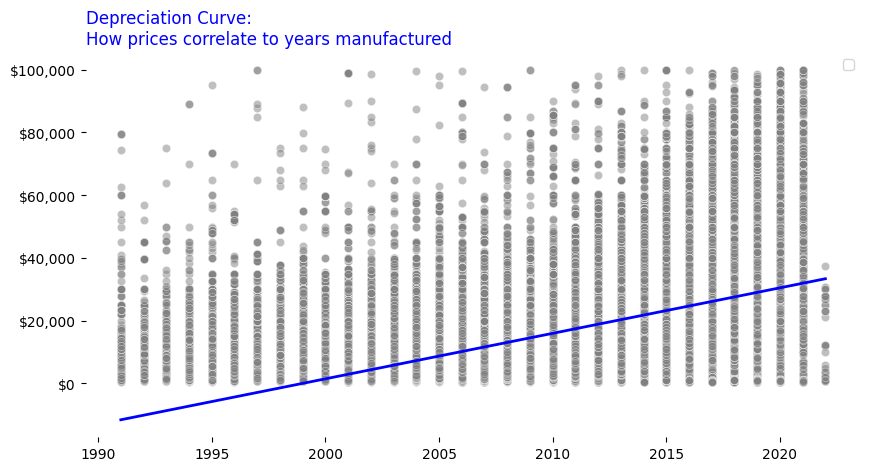

In [141]:
# Scatter plot
plt.figure(figsize=(10, 5))
ax = sns.scatterplot(data=df_filtered, x="year", y="price", alpha=0.5, color="gray")

# Plot the regression line
plt.plot(years, predicted_prices, color="blue", linewidth=2)

# Remove borders
for spine in ax.spines.values():
    spine.set_visible(False)

plt.title("Depreciation Curve:\nHow prices correlate to years manufactured", loc="left", color="blue")
plt.xlabel("")
plt.ylabel("")
plt.legend()

# Format y-axis ticks with dollar sign and commas
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick)

plt.show()


## Pricing outliers

#### Z score, also called as standard score, is used to scale the features in a dataset for machine learning model training. Here I AM simply applying it to determine which items are priced irregularly (meaning the price falls very far from the mean).

$$
Z-score = \frac{x - mean}{std.deviation}
$$

#### If the z score of a data point is more than 3, it indicates that the data point is quite different from the other data points. Such a data point can be an outlier. I am using the `stats` package to calculate z-score directly.

/var/folders/rn/yjyn25416fq_ty8w0zc5f06m0000gn/T/ipykernel_4648/2746189144.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["z_score"] = stats.zscore(df_filtered["price"])
/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


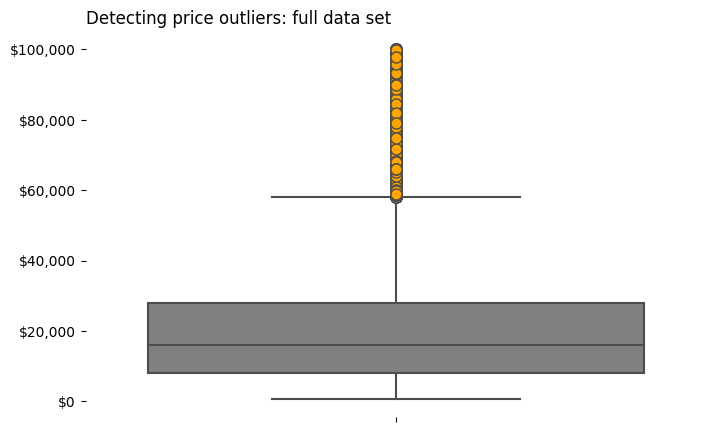

Outliers based on Z-score analysis:
     manufacturer                            model  year  price   z_score
346       ferrari                       360 modena  2001  98900  5.570403
365     chevrolet                            tahoe  2021  72900  3.751561
461     chevrolet           corvette stingray spor  2021  99950  5.643856
807       unknown  Freightliner M2 106 Medium Duty  2017  63990  3.128258
829          ford             super duty f-550 drw  2016  62990  3.058303
906          ford      f750 four car hauler rollba  2012  69950  3.545193
1173    chevrolet                         corvette  2017  69850  3.538197
1881         ford               expedition limited  2020  64998  3.198773
1886          ram                     2500 laramie  2020  63814  3.115946
2042          gmc             sierra 3500hd denali  2020  82998  4.457971


In [204]:
from scipy import stats

# Compute Z-scores for price column
df_filtered["z_score"] = stats.zscore(df_filtered["price"])

# Define outliers (|Z-score| > 3)
outliers = df_filtered[abs(df_filtered["z_score"]) > 3]

# Box plot with outliers
plt.figure(figsize=(8, 5))
ax = sns.boxplot(data=df_filtered, y="price", color="gray",
                 flierprops = dict(markerfacecolor='orange', marker='o', markersize=8)
                )

plt.title("Detecting price outliers: full data set", loc="left")
plt.ylabel("")

# Remove borders
for spine in ax.spines.values():
    spine.set_visible(False)

# Format y-axis ticks with dollar sign and commas
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick)

plt.show()

# Print detected outliers
print("Outliers based on Z-score analysis:")
print(outliers[["manufacturer", "model", "year", "price", "z_score"]].head(10))

#### This is of course unfair, not taking into account the difference in brands and years manufactured. I will use some characteristics of a certain brand, the type of car, and the year to uncover irregular pricing.
#### In real life, used car prices are also determined by other factors, including the car's condition, mileage, and location (consider supply and demand). The price may also vary depending on the time of year and whether the car is being sold by a dealership or private seller.

#### A friend told me that nothing is more expensive than cheap European cars, and nothing is cheaper than expensive Toyota...
#### Let see how these two types are priced for the year 2020, for example.

In [178]:
df_filtered[df_filtered['year'] == 2020].describe(include='object')

region manufacturer                      model  \
count                      17414        17414                      17414   
unique                       389           35                       1858   
top     kennewick-pasco-richland         ford  ranger supercab xl pickup   
freq                         182         2670                        353   

       condition    cylinders   fuel title_status transmission  drive  \
count      12183         6497  17314        17110        17350  10926   
unique         6            7      5            5            3      3   
top         good  6 cylinders    gas        clean        other    4wd   
freq        9944         2993  13173        16856         9352   4514   

             size   type paint_color  \
count        1358  15435       13262   
unique          4     13          12   
top     full-size  sedan       white   
freq          728   3325        4397   

                                              description  state  \
count                                               17413  17414   
unique                                              15922     51   
top     2020 Ford F-250 SUPERDUTY LIFTED STX 8FT 6.7L ...     ca   
freq                                                   33   1646   

                    posting_date  
count                      17414  
unique                     16710  
top     2021-04-08T09:51:15-0400  
freq                           4

In [180]:
df_compare_pricing = df_filtered[(df_filtered['year'] == 2020) & (df_filtered['type'] == 'sedan') & \
(df_filtered['manufacturer'].isin(['toyota', 'bmw']))]

In [182]:
df_compare_pricing['manufacturer'].value_counts()

manufacturer
toyota    310
bmw       194
Name: count, dtype: int64

In [186]:
# Calculate the Z-score for the price column within each manufacturer group
df_compare_pricing['zscore2'] = df_compare_pricing.groupby('manufacturer')['price'].transform(lambda x: stats.zscore(x))

# Detect outliers (Z-score > 3 or < -3)
outliers_zscore = df_compare_pricing[df_compare_pricing['zscore2'].abs() > 3]

/var/folders/rn/yjyn25416fq_ty8w0zc5f06m0000gn/T/ipykernel_4648/2000915187.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_compare_pricing['zscore2'] = df_compare_pricing.groupby('manufacturer')['price'].transform(lambda x: stats.zscore(x))


/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/thaochu/anaconda3/envs/data-analytics/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


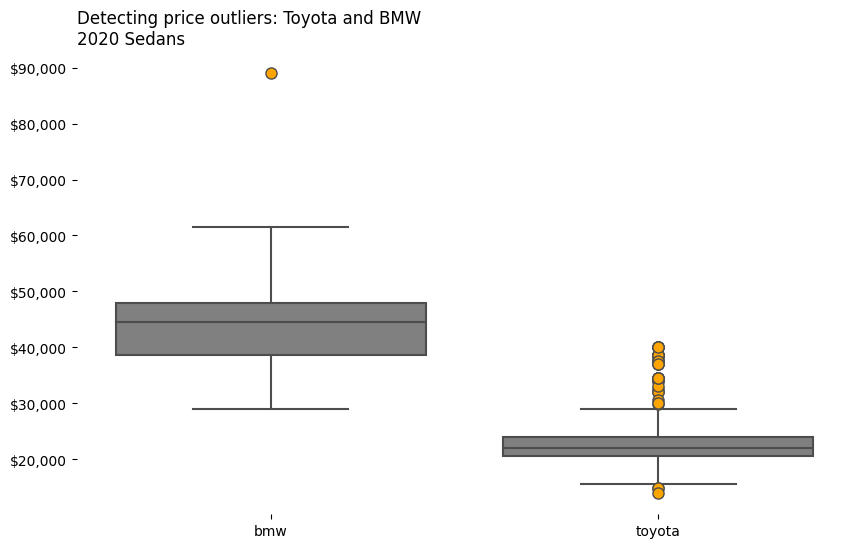

In [205]:
plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=df_compare_pricing, x='manufacturer', y='price', color='gray',
                                 flierprops = dict(markerfacecolor='orange', marker='o', markersize=8))

plt.title("Detecting price outliers: Toyota and BMW\n2020 Sedans", loc="left")
plt.ylabel("")
plt.xlabel("")

# Remove borders
for spine in ax.spines.values():
    spine.set_visible(False)

# Format y-axis ticks with dollar sign and commas
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick)


plt.show()

In [196]:
# Print detected outliers
print("Outliers based on Z-score analysis:")
print(outliers_zscore[["manufacturer", "model", "year", "price", "z_score", "zscore2"]])

Outliers based on Z-score analysis:
       manufacturer                    model  year  price   z_score   zscore2
32958        toyota      avalon trd sedan 4d  2020  39990  1.449327  3.168518
249185       toyota  avalon touring sedan 4d  2020  39990  1.449327  3.168518
267874          bmw                       m5  2020  88995  4.877494  5.701936
275176       toyota      avalon trd sedan 4d  2020  39990  1.449327  3.168518
358760       toyota      avalon trd sedan 4d  2020  39990  1.449327  3.168518
366175       toyota  avalon touring sedan 4d  2020  39990  1.449327  3.168518


# Are car colors dissappearing...

In [35]:
df_filtered.shape

(369586, 23)

In [41]:
df[['paint_color', 'price']].describe(include='object')

paint_color
count       296677
unique          12
top          white
freq         79285

In [47]:
df_ford = df_filtered[df_filtered["manufacturer"] == 'ford']

In [49]:
df_ford['paint_color'].value_counts()

paint_color
white     16656
black      7619
silver     4485
red        4460
blue       4175
grey       2969
green      1056
custom      990
brown       745
yellow      297
orange      271
purple       59
Name: count, dtype: int64

In [ ]:
# Define neutral colors
neutral_colors = ["white", "black", "gray", "silver"]

# Create color category
df_ford["color_category"] = df_ford["paint_color"].apply(lambda x: "Neutral colors" if x in neutral_colors else "Others")

# Group by year and color category to calculate average price
df_avg_price = df_ford.groupby(["year", "color_category"])["price"].mean().reset_index()

# Pivot the data for better visualization
df_pivot = df_avg_price.pivot(index="year", columns="color_category", values="price")

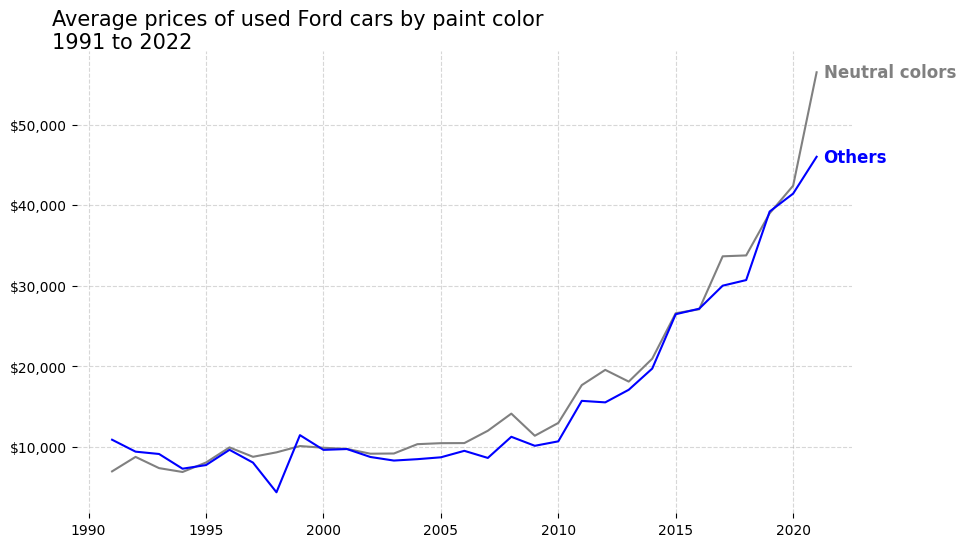

In [144]:
# Plot the line chart
plt.figure(figsize=(10, 6))
plt.plot(df_pivot.index, df_pivot["Neutral colors"], label="Neutral colors", color="gray")
plt.plot(df_pivot.index, df_pivot["Others"], label="Others", color="blue")

# Add inline labels at the end of each line
for category, color in zip(["Neutral colors", "Others"], ["gray", "blue"]):
    last_valid_index = df_pivot[category].last_valid_index()  # Get last year with a valid price
    last_valid_value = df_pivot.loc[last_valid_index, category]  # Get price for that year
    
    plt.annotate(
        category, 
        xy=(last_valid_index, last_valid_value),  # Use last available data
        xytext=(5, 0), 
        textcoords="offset points", 
        ha="left", 
        va="center", 
        fontsize=12, 
        color=color, 
        fontweight="bold"
    )

# Remove chart borders
for spine in plt.gca().spines.values():
    spine.set_visible(False)

# Left-align the title
plt.suptitle("Average prices of used Ford cars by paint color\n1991 to 2022", x=0.1, y=0.95,horizontalalignment='left', verticalalignment='top', fontsize = 15)


# Chart labels
plt.xlabel("")
plt.ylabel("")
plt.grid(True, linestyle="--", alpha=0.5)

# Format y-axis ticks with dollar sign and commas
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
plt.gca().yaxis.set_major_formatter(tick)

# Remove legend since labels are inline
plt.legend().set_visible(False)


# Show plot
plt.show()

In [96]:
df_ford[(df_ford['color_category'] == "Others") & (df_ford['year'] == 2022)]['description'].tolist()

['I buy unwanted cars trucks suvs camper trailers rvs and more if you have anything you wanna sell call me and get paid same day  All items purchased must have a clean and clear title  Call big mike  show contact info  if no answer please text thanks and god bless',
 'Hollingsworth Auto Sales needs inventory We want to buy your car, truck or suv! $5k to $100k  We are a family owned and operated business that has been buying vehicles from individuals for almost 40 years. We will beat any written offer for your vehicle.  3808 Capital Blvd Raleigh NC 27604  *truck is not for sale*',
 'Clean Title  *2002 * FORD * EXPLORER *EDDIE BAUER *4WD*4 DOOR WAGON/SPORT UTILITY* 4.6L V8 F SOHC 16V *ALL WHEEL DRIVE *LEATHER SEATS * THIRD ROW SEATING * TOW HITCH *HEATED SEATS * POWER LOCKS *PORWER WINDOWS *    Presented by: Pacific Motors LLC -- (971) 312-5503 --   This clean title  Vehicle is in excellent condition with 139,700Miles . BUY WITH CONFIDENCE, EXTENDED WARRANTY AVAILABLE. (90 DAYS AND MORE)

In [103]:
df_pivot.tail(5)

color_category  Neutral colors        Others
year                                        
2018              33769.386398  30708.179521
2019              38998.197908  39219.732938
2020              42427.735913  41446.414369
2021              56512.649123  46018.290698
2022                       NaN   9045.000000

#### The data was scraped ending 2021, thus these postings for 2022 used cars are unrealistic and would be omitted for human error. We now remove data in this year and plot again.

In [104]:
# Remove the year 2022 from df_pivot
df_pivot = df_pivot[df_pivot.index != 2022]

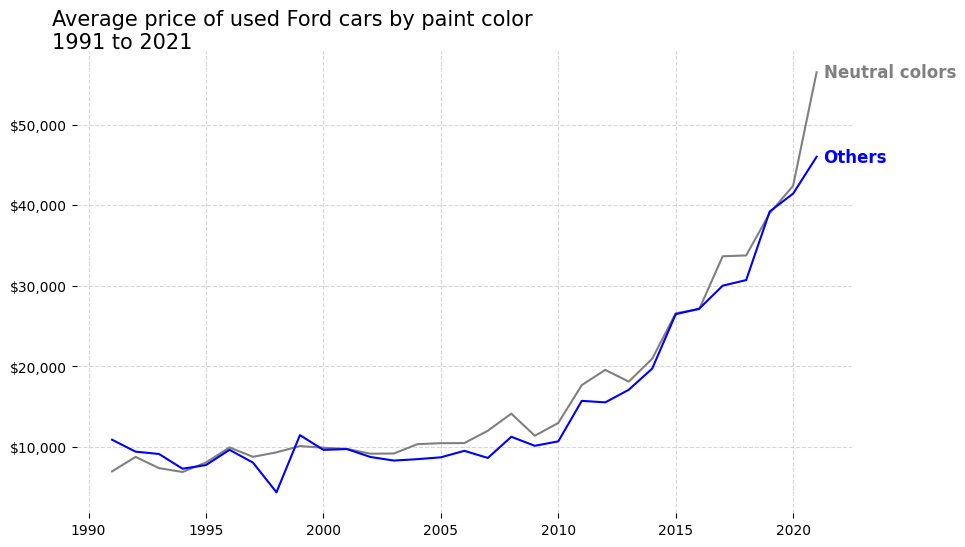

In [239]:
# Plot the line chart
plt.figure(figsize=(10, 6))
plt.plot(df_pivot.index, df_pivot["Neutral colors"], label="Neutral colors", color="gray")
plt.plot(df_pivot.index, df_pivot["Others"], label="Others", color="blue")

# Add inline labels at the end of each line
for category, color in zip(["Neutral colors", "Others"], ["gray", "blue"]):
    last_valid_index = df_pivot[category].last_valid_index()  # Get last year with a valid price
    last_valid_value = df_pivot.loc[last_valid_index, category]  # Get price for that year
    
    plt.annotate(
        category, 
        xy=(last_valid_index, last_valid_value),  # Use last available data
        xytext=(5, 0), 
        textcoords="offset points", 
        ha="left", 
        va="center", 
        fontsize=12, 
        color=color, 
        fontweight="bold"
    )

# Remove chart borders
for spine in plt.gca().spines.values():
    spine.set_visible(False)

# Left-align the title
plt.suptitle("Average price of used Ford cars by paint color\n1991 to 2021", x=0.1, y=0.95,horizontalalignment='left', verticalalignment='top', fontsize = 15)


# Chart labels
plt.xlabel("")
plt.ylabel("")
plt.grid(True, linestyle="--", alpha=0.5)

# Remove legend since labels are inline
plt.legend().set_visible(False)

# Format y-axis ticks with dollar sign and commas
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
plt.gca().yaxis.set_major_formatter(tick)

# Show plot
plt.show()

## Comparing with all cars

In [206]:
df_filtered["color_category"] = df_filtered["paint_color"].apply(lambda x: "Neutral colors" if x in neutral_colors else "Others")

# Group by year and color category to calculate average price
df_avg_price_all = df_filtered.groupby(["year", "color_category"])["price"].mean().reset_index()

# Pivot the data for better visualization
df_pivot_all = df_avg_price_all.pivot(index="year", columns="color_category", values="price")

/var/folders/rn/yjyn25416fq_ty8w0zc5f06m0000gn/T/ipykernel_4648/1695987609.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["color_category"] = df_filtered["paint_color"].apply(lambda x: "Neutral colors" if x in neutral_colors else "Others")


In [208]:
# Remove the year 2022 from df_pivot
df_pivot_all = df_pivot_all[df_pivot_all.index != 2022]

In [233]:
paint_color= 'paint color'

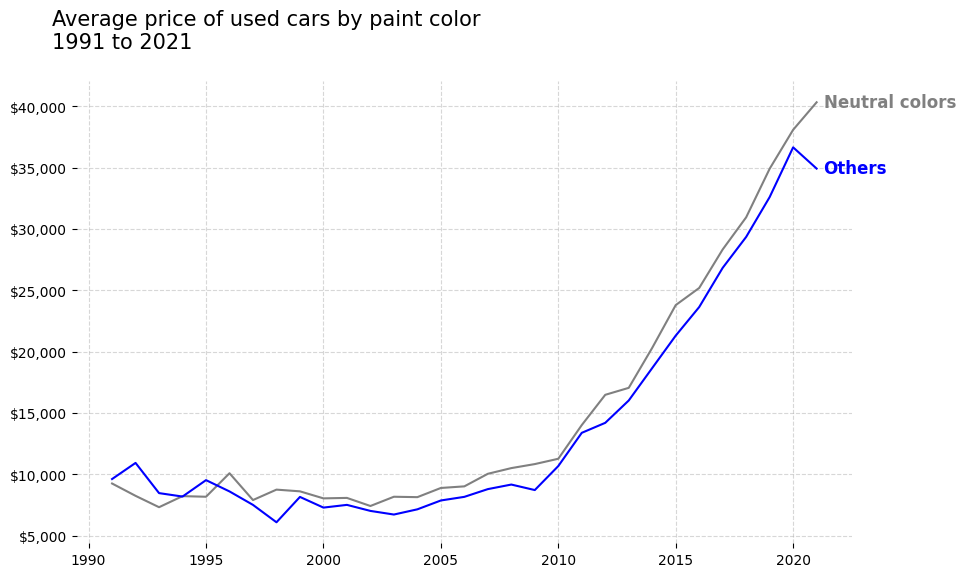

In [238]:
# Plot the line chart
plt.figure(figsize=(10, 6))
plt.plot(df_pivot_all.index, df_pivot_all["Neutral colors"], label="Neutral colors", color="gray")
plt.plot(df_pivot_all.index, df_pivot_all["Others"], label="Others", color="blue")

# Add inline labels at the end of each line
for category, color in zip(["Neutral colors", "Others"], ["gray", "blue"]):
    last_valid_index = df_pivot_all[category].last_valid_index()  # Get last year with a valid price
    last_valid_value = df_pivot_all.loc[last_valid_index, category]  # Get price for that year
    
    plt.annotate(
        category, 
        xy=(last_valid_index, last_valid_value),  # Use last available data
        xytext=(5, 0), 
        textcoords="offset points", 
        ha="left", 
        va="center", 
        fontsize=12, 
        color=color, 
        fontweight="bold"
    )

# Remove chart borders
for spine in plt.gca().spines.values():
    spine.set_visible(False)

# Left-align the title
plt.suptitle("Average price of used cars by paint color\n1991 to 2021", 
             x=0.1, y=1, horizontalalignment='left', verticalalignment='top', fontsize=15)


# Chart labels
plt.xlabel("")
plt.ylabel("")
plt.grid(True, linestyle="--", alpha=0.5)

# Format y-axis ticks with dollar sign and commas
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
plt.gca().yaxis.set_major_formatter(tick)

# Remove legend since labels are inline
plt.legend().set_visible(False)


# Show plot
plt.show()

## What about median price?

In [211]:
# Group by year and color category to calculate average price
df_median_price_all = df_filtered.groupby(["year", "color_category"])["price"].median().reset_index()

# Pivot the data for better visualization
df_median_pivot_all = df_median_price_all.pivot(index="year", columns="color_category", values="price")

# Remove the year 2022 from df_pivot
df_median_pivot_all = df_median_pivot_all[df_median_pivot_all.index != 2022]

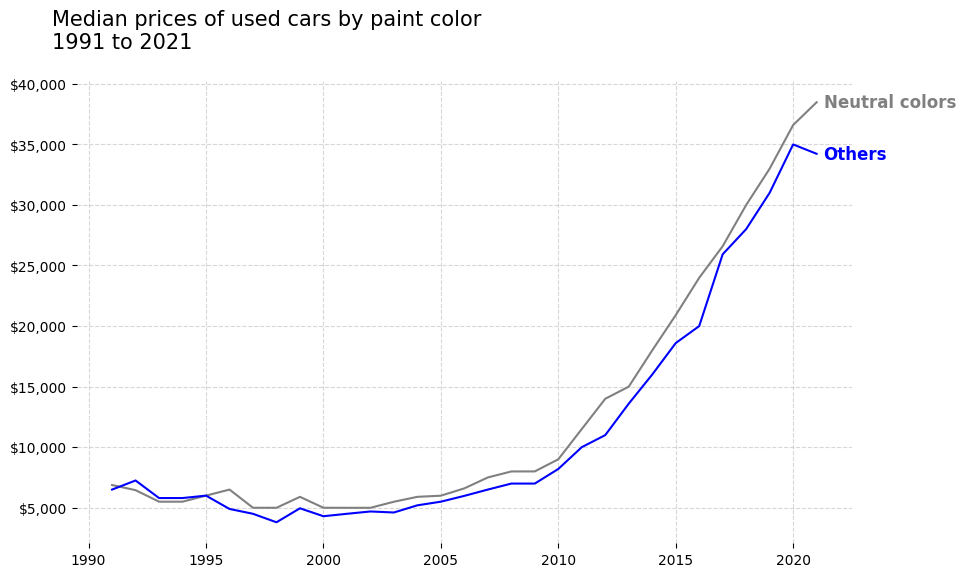

In [240]:
# Plot the line chart
plt.figure(figsize=(10, 6))
plt.plot(df_median_pivot_all.index, df_median_pivot_all["Neutral colors"], label="Neutral colors", color="gray")
plt.plot(df_median_pivot_all.index, df_median_pivot_all["Others"], label="Others", color="blue")

# Add inline labels at the end of each line
for category, color in zip(["Neutral colors", "Others"], ["gray", "blue"]):
    last_valid_index = df_median_pivot_all[category].last_valid_index()  # Get last year with a valid price
    last_valid_value = df_median_pivot_all.loc[last_valid_index, category]  # Get price for that year
    
    plt.annotate(
        category, 
        xy=(last_valid_index, last_valid_value),  # Use last available data
        xytext=(5, 0), 
        textcoords="offset points", 
        ha="left", 
        va="center", 
        fontsize=12, 
        color=color, 
        fontweight="bold"
    )

# Remove chart borders
for spine in plt.gca().spines.values():
    spine.set_visible(False)

# Left-align the title
plt.suptitle("Median prices of used cars by paint color\n1991 to 2021", x=0.1, y=1,horizontalalignment='left', verticalalignment='top', fontsize = 15)


# Chart labels
plt.xlabel("")
plt.ylabel("")
plt.grid(True, linestyle="--", alpha=0.5)

# Format y-axis ticks with dollar sign and commas
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
plt.gca().yaxis.set_major_formatter(tick)

# Remove legend since labels are inline
plt.legend().set_visible(False)


# Show plot
plt.show()